In [1]:
import itertools

import multiprocess
import numpy as np
import pymatching
import scipy.optimize
import stim
from matplotlib import pyplot as plt

In [2]:
def calc(circuit: stim.Circuit, shots: int, batches: int = 10) -> tuple[float, float]:
    sampler = circuit.compile_detector_sampler()
    model = circuit.detector_error_model(decompose_errors=True)
    matcher = pymatching.Matching.from_detector_error_model(model)

    def _count() -> float:
        detection_events, observable_flips = sampler.sample(
            shots, separate_observables=True
        )
        predictions = matcher.decode_batch(detection_events)
        return np.any(observable_flips != predictions, axis=1).mean()

    res = [_count() for _ in range(batches)]
    return np.mean(res), np.std(res)

In [3]:
def plot(distances: np.ndarray, rounds: np.ndarray, res: np.ndarray):
    _, axs = plt.subplots(1, 2, figsize=(10, 4))

    # First subplot
    for i in range(len(distances)):
        y = res[i, :, 0]
        y1, y2 = y - res[i, :, 1], y + res[i, :, 1]
        axs[0].semilogy(rounds, y, marker="o", label=f"Distance {distances[i]}")
        axs[0].fill_between(rounds, y1, y2, alpha=0.2)
    axs[0].set_xlabel("Rounds")
    axs[0].set_ylabel("Logical error probability")
    axs[0].legend()
    axs[0].grid()

    # Second subplot
    def fit(d, Λ, C):
        return C / Λ ** ((d + 1) / 2)

    y, y_err = res[:, -1, 0], res[:, -1, 1]
    popt, pcov = scipy.optimize.curve_fit(
        fit, distances, y, sigma=y_err, absolute_sigma=True
    )

    axs[1].semilogy(
        distances,
        fit(distances, *popt),
        "--",
        label=f"Fit: $\\Lambda = {popt[0]:.3f}\\pm{pcov[0, 0]:.3f}$",
    )
    axs[1].semilogy(distances, y, "o")
    axs[1].fill_between(distances, y - y_err, y + y_err, alpha=0.2)
    axs[1].set_xlabel("Distance")
    axs[1].set_ylabel("Logical error per round")
    axs[1].legend()

    plt.show()

## Repetition code

In [4]:
distances = np.arange(3, 12, 2)
rounds = np.arange(50) + 1
shots = 10**5
noise = 0.04

def repetition_code_circuit(distance: int, rounds: int):
    return stim.Circuit.generated(
    "repetition_code:memory",
        distance=distance,
        rounds=rounds,
        before_round_data_depolarization=noise,
        before_measure_flip_probability=noise,
    )

In [5]:
%%time
with multiprocess.Pool(16) as p:
    res = p.map(
        lambda t: calc(repetition_code_circuit(t[0], t[1]), shots),
        itertools.product(distances, rounds)
    )
res = np.reshape(res, (len(distances), len(rounds), 2))
print(res.shape)

(5, 50, 2)
CPU times: user 41.7 ms, sys: 42.6 ms, total: 84.2 ms
Wall time: 3min 2s


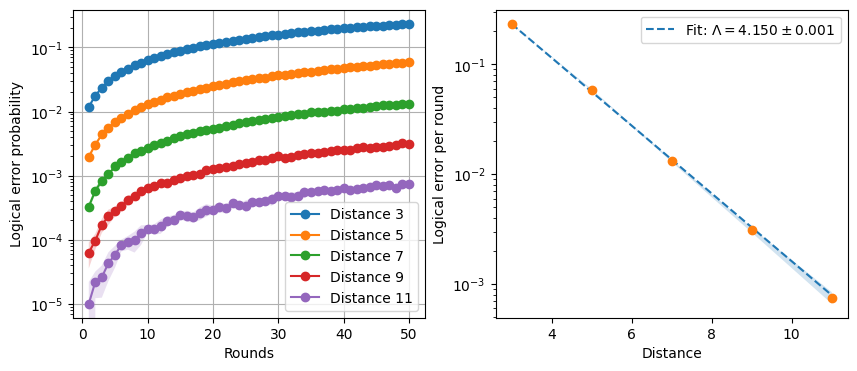

In [6]:
plot(distances, rounds, res)

## Surface code

In [7]:
distances = np.array([3, 5, 7, 9])
rounds = np.arange(30) + 1
shots = 10**5
noise = 0.004

def surface_code_circuit(distance: int, rounds: int):
    return stim.Circuit.generated(
        "surface_code:rotated_memory_z",
        distance=distance,
        rounds=rounds,
        after_clifford_depolarization=noise,
        after_reset_flip_probability=noise,
        before_measure_flip_probability=noise,
        before_round_data_depolarization=noise,
    )

In [8]:
%%time
with multiprocess.Pool(16) as p:
    res = p.map(
        lambda t: calc(surface_code_circuit(t[0], t[1]), shots),
        itertools.product(distances, rounds)
    )
res = np.reshape(res, (len(distances), len(rounds), 2))
print(res.shape)

(4, 30, 2)
CPU times: user 37.1 ms, sys: 74.5 ms, total: 112 ms
Wall time: 4min 48s


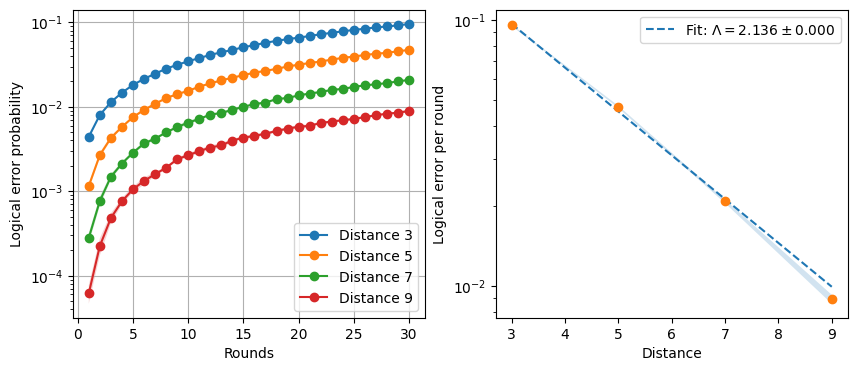

In [9]:
plot(distances, rounds, res)